# T1 By Joseph

In [1]:
import re
import numpy as np
import scipy.ndimage
import scipy.signal
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import pandas as pd
from scipy.optimize import curve_fit
from pathlib import Path

# Data ingestion

In [2]:
def parse_concentration_files(directory_path):
    """
    Parse files in a directory and return separate dictionaries for Cu and Fe files.
    
    Expected filename format: T1[Cu|Fe]M<concentration>
    Example: T1CuM1e-3.csv, T1FeM5e-4.txt
    
    Args:
        directory_path (str): Path to the directory containing the files
        
    Returns:
        tuple: (cu_dict, fe_dict) where each dict maps concentration values (float) to DataFrames
    """
    cu_dict = {}
    fe_dict = {}
    directory = Path(directory_path)
    
    # Check if directory exists
    if not directory.exists():
        raise ValueError(f"Directory '{directory_path}' does not exist")
    
    # Pattern to match: T1, then Cu or Fe (captured), then M, then scientific notation
    pattern = r'^T1(Cu|Fe)M(\d+\.?\d*e[+-]?\d+)'
    
    # Iterate through files in directory
    for file_path in directory.iterdir():
        if file_path.is_file():
            filename = file_path.name
            
            # Try to match the pattern
            match = re.match(pattern, filename)
            if match:
                element = match.group(1)  # 'Cu' or 'Fe'
                concentration_str = match.group(2)
                
                try:
                    # Convert scientific notation string to float
                    # Handle formats like: 1e-3, 5e-4, 2.5e-5, etc.
                    concentration_value = float(concentration_str)
                    
                    # Read the file into a DataFrame
                    # Try common file formats
                    try:
                        if file_path.suffix.lower() == '.csv':
                            df = pd.read_csv(file_path)
                        elif file_path.suffix.lower() in ['.xlsx', '.xls']:
                            df = pd.read_excel(file_path)
                        elif file_path.suffix.lower() == '.txt':
                            # Assume tab-delimited for .txt files
                            df = pd.read_csv(file_path, sep='\t')
                        else:
                            # Try CSV as default
                            df = pd.read_csv(file_path)
                        
                        # Add to appropriate dictionary
                        if element == 'Cu':
                            cu_dict[concentration_value] = df
                        else:  # element == 'Fe'
                            fe_dict[concentration_value] = df
                        
                    except Exception as e:
                        print(f"Warning: Could not read file '{filename}': {e}")
                        
                except ValueError:
                    print(f"Warning: Could not parse concentration from '{filename}'")
    
    return cu_dict, fe_dict
cu_data_dict, fe_data_dict = parse_concentration_files(r'.\PHY_541_T1_data')

# Utility functions

In [3]:
def extract_delta_times(df):
    """
    Extract delta times from column labels that contain 'D' followed by scientific notation.
    Returns a list of delta times corresponding to each column.
    """
    delta_times = []
    
    for col in df.columns:
        # Search for 'D' followed by scientific notation (e.g., D1.5e-3, D2.5E+2)
        match = re.search(r'D([-+]?\d+\.?\d*[eE][-+]?\d+)', str(col))
        if match:
            delta_time = float(match.group(1))
            delta_times.append(delta_time)
        else:
            delta_times.append(None)  # No match found
    
    return np.asarray(delta_times)

def get_unique_delta_times(df):
    """
    Get unique delta times from columns (accounting for triplet pattern).
    Returns unique delta times in order of appearance.
    """
    delta_times = extract_delta_times(df)
    unique_times = []
    seen = set()
    
    for dt in delta_times:
        if dt is not None and dt not in seen:
            unique_times.append(dt)
            seen.add(dt)
    
    return np.asarray(unique_times)
def sort_dataframe_by_time_array(df):
    """
    Sort dataframe columns in groups of 4 according to a time array.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataframe with columns in groups of 4, where each group has randomized time values
    
    Returns:
    --------
    pd.DataFrame
        Dataframe with column groups sorted according to time_array
    
    Example:
    --------
    # Assuming first row contains time values for each group
    df_sorted = sort_dataframe_by_time_array(df, time_array)
    """
    time_array = get_unique_delta_times(df)
    n_cols = len(df.columns)
    n_groups = n_cols // 4
    
    # Get the sorted order of the time array
    sorted_indices = np.argsort(time_array)
    
    # Build new column order based on sorted indices
    new_col_order = []
    for sorted_idx in sorted_indices:
        # Add all 4 columns from this group
        new_col_order.extend(range(sorted_idx * 4, (sorted_idx + 1) * 4))
    
    # Return dataframe with reordered columns
    return df.iloc[:, new_col_order]

def find_two_peaks_by_distance(peaks, properties, delta_t, tolerance=0.1):
    """
    Find the 2 peaks with the largest prominence that are approximately delta_t apart.
    
    Parameters:
    -----------
    peaks : ndarray
        Indices of peaks from find_peaks
    properties : dict
        Properties dictionary from find_peaks (must contain 'prominences')
    delta_t : float
        Target distance between peaks
    tolerance : float, optional
        Relative tolerance for distance matching (default: 0.1 means ±10%)
        
    Returns:
    --------
    tuple
        (peak1_idx, peak2_idx, distance, prominences)
        Returns (None, None, None, None) if no suitable pair is found
    """
    if 'prominences' not in properties:
        raise ValueError("Properties must contain 'prominences'. Run find_peaks with prominence parameter.")
    
    if len(peaks) < 2:
        return None, None, None, None
    
    prominences = properties['prominences']
    # Define acceptable distance range
    min_dist = delta_t * (1 - tolerance)
    max_dist = delta_t * (1 + tolerance)
    
    best_pair = None
    best_combined_prominence = -np.inf
    
    # Check all pairs of peaks
    for i in range(len(peaks)):
        for j in range(i + 1, len(peaks)):
            distance = abs(peaks[j] - peaks[i])
            
            # Check if distance is within tolerance
            if min_dist <= distance <= max_dist:
                combined_prominence = prominences[i] + prominences[j]
                
                if combined_prominence > best_combined_prominence:
                    best_combined_prominence = combined_prominence
                    best_pair = (i, j, distance, (prominences[i], prominences[j]))
    
    if best_pair is None:
        return None, None, None, None

    return best_pair

def get_t1_trial_data(data_dict, smoothing = 20, element = None):
    new_dict = {}
    for concentration, df in data_dict.items():
        df = sort_dataframe_by_time_array(df)
        sorted_times = np.sort(get_unique_delta_times(df))
        trial_count = len(df.columns)//4

        amp_data = np.empty(trial_count)
        for run in range(trial_count):
            ch2 = df.iloc[:,run*4 + 1]
            ch3 = df.iloc[:,run*4 + 2]
            ch4 = df.iloc[:,run*4 + 3]
            if smoothing:
                smoothed = scipy.ndimage.gaussian_filter(ch4, smoothing)
            else:
                smoothed = ch4
            drange = np.max(smoothed) - np.min(smoothed)
            prominance = drange*0.02, drange*0.7

            #Falling edge
            pulse_drange = np.max(ch3) - np.min(ch3)
            
            ch2_mask = ch2 > (np.min(ch2) + pulse_drange * 0.05)
            ch2_filter_idx = np.argwhere(ch2 == np.median(ch2[ch2_mask]))[-1]
            
            ch3_mask = ch3 > (np.min(ch3) + pulse_drange * 0.05)
            ch3_filter_idx = np.argwhere(ch3 == np.median(ch3[ch3_mask]))[-1]
            
            peaks, info = scipy.signal.find_peaks(-smoothed[ch3_filter_idx[0]:], prominence = prominance)
            
            *peaks, dist, peak_promiences = find_two_peaks_by_distance(peaks, info, 
                                (ch3_filter_idx - ch2_filter_idx), tolerance=0.1)

            if None in peaks:
                amp_data[run] = np.nan
                print(f"Coudn't Find peaks: Element: {element} Trial: {run} @ concentration {concentration:.3e}")
                continue

            #ref_voltage = np.percentile(smoothed, 65)
            signal_voltage = smoothed[peaks[-1]]
            amp_data[run] = peak_promiences[1]  # type: ignore
        
        new_dict[concentration] = np.vstack((sorted_times,amp_data))
    return new_dict
    
    i, j, distance, prominences = best_pair
    return peaks[i], peaks[j], distance, prominences

In [4]:
cu_amp_data = get_t1_trial_data(cu_data_dict, 10, 'Cu')
fe_amp_data = get_t1_trial_data(fe_data_dict, 10, 'Fe')

# T1 Calculations

In [8]:
def saturated_ir_model(t, A, T1):
    "A saturated inversion-recovery model: "
    "S_max(1 - exp(Trec/T1))(1 - B*exp(-t/T1))"
    '''
    We define a saturation constant (1 - exp{-T_recurance/T_1})
    due to the implicit bias from a varying total sequence time.
    This should constrain T_1 and the amplitude more appropriately
    '''
    T_recurrence = 0.000_7 # 700 \mu s
    return A * (1 - np.exp(-T_recurrence/T1))*(1.0 - 2.0 *np.exp(-t / T1))

def linear_model(c, m, b):
    return m * c + b

def fit_dataset(arr, sigma_y=5*4e-05):
    """
    arr shape (N,2): column0 = t, column1 = amplitude.
    sigma_y: float or array same length as y. If None, uses 5*q (user-provided).
    Returns: popt, perr, chi2_red, dof, t, y
    """
    arr = np.asarray(arr)
    if arr.shape[0] == 2:
        arr = np.transpose(arr)
    if arr.ndim != 2 or arr.shape[1] != 2:
        raise ValueError("Each dataset must be shape (N,2).")
    arr = arr[np.all(np.isfinite(arr), axis=1)]
    t = arr[:,0]
    y = arr[:,1]

    # initial guesses
    A0 = (np.max(y) - np.min(y)) / 2.0 if np.ptp(y) > 0 else (np.max(np.abs(y)) or 1.0)
    T1_0 = max((t.max() - t.min())/2.0, 1.0)
    p0 = [A0, T1_0]

    lower = [-np.inf, 1e-12]
    upper = [np.inf, np.inf]

    if sigma_y is None:
        # set q if you want explicit numeric: q = 20e-3/256  # 20 mV full-scale
        # sigma_y = 5 * q
        raise ValueError("sigma_y must be provided (use your 5*q value).")

    sigma_arr = np.full_like(y, float(sigma_y)) if np.isscalar(sigma_y) else np.asarray(sigma_y)
    try:
        popt, pcov = curve_fit(saturated_ir_model, t, y, p0=p0, bounds=(lower, upper),
                            sigma=sigma_arr, absolute_sigma=True, maxfev=20000)
    except Exception:
        popt, pcov = curve_fit(saturated_ir_model, t, y, p0=p0, maxfev=20000)
    perr = np.sqrt(np.diag(pcov)) if pcov is not None else np.full(len(popt), np.nan)

    # chi2 reduced
    residuals = y - saturated_ir_model(t, *popt)
    chi2 = np.sum((residuals / sigma_arr) ** 2)
    dof = max(len(y) - len(popt), 1)
    chi2_red = chi2 / dof

    return popt, perr, chi2_red, dof, t, y


def regress_T1_vs_conc(concs, T1s, T1_errs=None):
    """
    Linear regression T1 = m*conc + b.
    Uses weighted fit if T1_errs provided and non-zero.
    Returns (m, b, m_err, b_err, r2)
    """
    popt_lin, pcov_lin = curve_fit(linear_model, concs, T1s,
                               sigma=T1_errs, absolute_sigma=True)
    m, b = popt_lin
    m_err, b_err = np.sqrt(np.diag(pcov_lin))

    # reduced chi2 for this fit
    res = T1s - linear_model(concs, *popt_lin)
    chi2_lin = np.sum((res / T1_errs) ** 2)
    dof_lin = max(len(concs) - len(popt_lin), 1)
    chi2_red_lin = chi2_lin / dof_lin

    return m, b, m_err, b_err, chi2_lin

In [13]:
def compute_chi_squared(arr, popt, sigma_y):
    local_arr = np.permute_dims(arr)
    t = local_arr[:, 0]
    y = local_arr[:, 1]
    A, T1 = popt
    y_fit = saturated_ir_model(t, A, T1)

    residuals = y - y_fit
    chi2 = np.sum((residuals / sigma_y) ** 2)
    dof = len(t) - len(popt)
    chi2_red = chi2 / dof
    return chi2, chi2_red

def fit_and_plot(dict_of_dicts, out_filename=None, figsize=(12,9),
                 cmap_name='viridis'):
    """
    dict_of_dicts: mapping label -> data_dict (concentration->array (N,2))
    q_mv: ADC full-scale in mV (default 20 mV -> q = 20e-3 / 256)
    quant_steps: number of quant steps representing the per-point uncertainty (user stated 5)
    Returns: t1_results = {label: {conc: (T1_sec, T1_err_sec), ...}, ...}
    """
    cmap = cm._colormaps.get_cmap(cmap_name)

    species = list(dict_of_dicts.keys())

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.7], hspace=0.35, wspace=0.28)
    ax_top_left = fig.add_subplot(gs[0,0])
    ax_top_right = fig.add_subplot(gs[0,1])
    ax_bot_left = fig.add_subplot(gs[1,0])
    ax_bot_right = fig.add_subplot(gs[1,1])
    axs_top = [ax_top_left, ax_top_right]
    axs_bot = [ax_bot_left, ax_bot_right]

    t1_results = {}

    time_scale = 1000.0   # display t in ms
    amp_scale = 1000.0    # display amp in mV
    fig.suptitle('$T_1$ Data and Regressions')
    for i, label in enumerate(species):
        ax = axs_top[i] if i < 2 else axs_top[-1]
        ax.set_title(f'{label} Echo Time to Delay Time')
        ax.set_xlabel("Delay time (ms)")
        ax.set_ylabel("Echo amplitude (mV)")
        ax.minorticks_on()
        ax.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.6)
        ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

        data_dict = dict_of_dicts[label]
        t1_results[label] = {}

        if not data_dict:
            continue

        concs_sorted = np.array(sorted(map(float, data_dict.keys())))
        norm = Normalize(vmin=concs_sorted.min(), vmax=concs_sorted.max(), clip=True)
        print(label)
        for conc in sorted(map(float, data_dict.keys())):
            arr = np.asarray(data_dict[conc])
            
            popt, perr, chi2_red, dof, t, y = fit_dataset(arr, sigma_y = amp_stdev)

            A, T1 = popt
            A_err, T1_err = perr if perr is not None else (np.nan, np.nan)

            t_smooth = np.linspace(t.min(), t.max(), 300)
            y_fit = saturated_ir_model(t_smooth, *popt)
            color = cmap(norm(conc))

            ax.scatter(time_scale * t, amp_scale * y, s=30, marker='o', color=color,
                       alpha=0.9, edgecolor='k', linewidth=0.3, zorder=2)
            ax.plot(time_scale * t_smooth, amp_scale * y_fit, color=color, linewidth=1.6, zorder=1)

            t1_results[label][conc] = (float(T1), float(T1_err))

            chi2, chi2_red = compute_chi_squared(arr, popt, sigma_y=amp_stdev)
            print(f'T1 for concentration: {conc:.3e} M')
            print(f"\tChi² = {chi2:.3e}, Reduced Chi² = {chi2_red:.3f}")


    lin_fit_stats = {}
    # Bottom row: T1 vs concentration with vertical error bars and weighted linear fit
    for i, label in enumerate(species):
        axb = axs_bot[i]
        axb.set_xlabel("Concentration (M)")
        axb.set_ylabel("T1 (ms)")
        axb.minorticks_on()
        axb.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.6)
        axb.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

        results = t1_results.get(label, {})
        if not results:
            continue

        concs = np.array(sorted(results.keys()), dtype=float)
        T1s_s = np.array([results[c][0] for c in concs], dtype=float)
        T1_errs_s = np.array([results[c][1] for c in concs], dtype=float)

        # convert to ms for plotting and fitting
        T1s_ms = T1s_s * 1000.0
        T1_errs_ms = T1_errs_s * 1000.0

        norm = Normalize(vmin=concs.min(), vmax=concs.max(), clip=True)


        axb.scatter(concs, T1s_ms, c=concs, cmap=cmap, norm=norm,
                        s=60, edgecolor='k', linewidth=0.3, zorder=2)

        good_mask = np.isfinite(T1s_ms) & np.isfinite(concs)
        chi2_lin = np.nan
        chi2_red_lin = np.nan
        m = b = m_err = b_err = r2 = np.nan

        
        x = concs[good_mask]
        y = T1s_ms[good_mask]

        idx = np.where(good_mask)[0]
        xw = concs[idx] 
        yw = T1s_ms[idx]
        yw_err = T1_errs_ms[idx]

        yw_err_safe = np.maximum(yw_err, 1e-8)

        popt_pow, pcov_pow = curve_fit(
            lambda X, A, B: A * np.power(X, B),
            xw, yw,
            absolute_sigma=True
        )
        #    sigma=yw_err_safe,
        a, b = popt_pow
        a_err, b_err = np.sqrt(np.diag(pcov_pow))

        # chi2 on points used in fit
        yhat = a * np.power(xw, b)
        chi2_lin = np.sum(((yw - yhat) / yw_err_safe) ** 2)
        p = 2
        dof_lin = max(0, xw.size - p)
        chi2_red_lin = chi2_lin / dof_lin if dof_lin > 0 else np.nan

        # R^2 computed on the same good points
        ss_res = np.nansum((yw - yhat) ** 2)
        ss_tot = np.nansum((yw - np.nanmean(yw)) ** 2)
        r2 = 1.0 - ss_res / ss_tot if ss_tot != 0 else np.nan

        # plot fitted curve (log-log)
        x_min = np.min(concs[concs > 0])
        x_max = np.max(concs)
        x_line = np.logspace(np.log10(x_min), np.log10(x_max), 200)
        axb.loglog(x_line, a * np.power(x_line, b), '--', color='gray', linewidth=1.6)

        lin_fit_stats[label] = {'Chi2' : chi2_lin, 'Chi2_red' : chi2_red_lin, 
                                'a' : a, 'b' : b, 
                                'delta a' : a_err, 'delta b': b_err, 'r2' : r2}

        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                            ax=axb, orientation='vertical', pad=0.06)
        cbar.set_label("Concentration (M)")
        axb.set_title(fr'Weighted Reg. $T_1$ to Con. $\hat{{y}} = {a:.4f}x^{{{b:.3}}}$')
    if out_filename:
        fig.savefig(out_filename, bbox_inches='tight', dpi=200)

    return t1_results, lin_fit_stats

Cu
T1 for concentration: 4.800e-02 M
	Chi² = 3.801e+00, Reduced Chi² = 0.292
T1 for concentration: 8.000e-02 M
	Chi² = 1.694e+00, Reduced Chi² = 0.130
T1 for concentration: 1.000e-01 M
	Chi² = 2.397e+00, Reduced Chi² = 0.184
T1 for concentration: 1.600e-01 M
	Chi² = 6.443e-01, Reduced Chi² = 0.050
T1 for concentration: 2.500e-01 M
	Chi² = 5.031e-01, Reduced Chi² = 0.039
T1 for concentration: 3.200e-01 M
	Chi² = 2.853e-01, Reduced Chi² = 0.022
T1 for concentration: 4.800e-01 M
	Chi² = 3.584e-02, Reduced Chi² = 0.003
T1 for concentration: 6.600e-01 M
	Chi² = 5.676e-02, Reduced Chi² = 0.004
T1 for concentration: 7.500e-01 M
	Chi² = 7.214e-02, Reduced Chi² = 0.006
Fe
T1 for concentration: 2.500e-03 M
	Chi² = 1.367e-01, Reduced Chi² = 0.011
T1 for concentration: 5.000e-03 M
	Chi² = 1.370e-01, Reduced Chi² = 0.011
T1 for concentration: 1.000e-02 M
	Chi² = 1.847e-01, Reduced Chi² = 0.014
T1 for concentration: 1.500e-02 M
	Chi² = 4.384e-02, Reduced Chi² = 0.003
T1 for concentration: 2.500e-02 

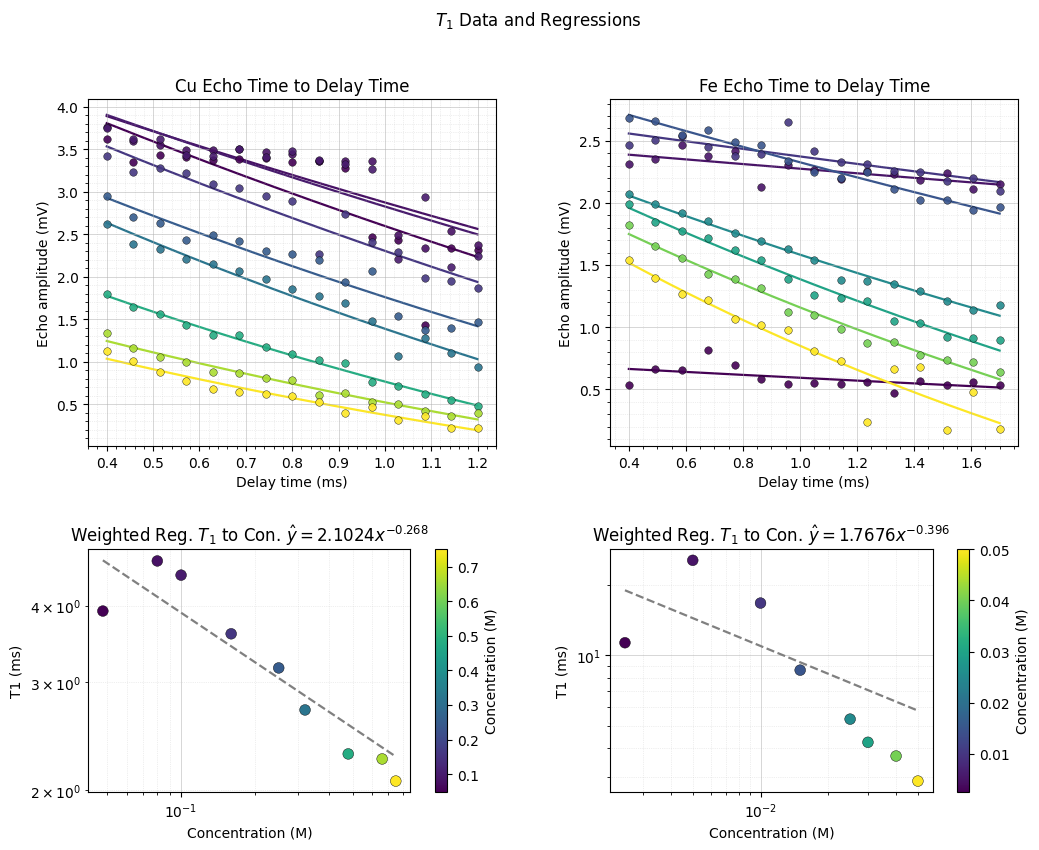

In [14]:
amp_stdev = 0.0007266152786417003 # Stdandard deviation of last 200 samples after the pulse.
results_dict, conc_reg_stats = fit_and_plot({'Cu': cu_amp_data, 'Fe': fe_amp_data})